## Facebook Messenger tools

I decided to download all my facebook messenger data and explore some of my conversations. This one (with my good friend Dmitri) has been running for around 8 years, so there's plenty of data. 

In [1]:
import numpy as np
import pandas as pd
import json
from collections import Counter
from matplotlib import pyplot as plt
import re
import glob

In [2]:
PATH_TO_CONVERSATIONS = 'data/messages/inbox/'

#Function to get all conversation names
def get_names():
    for p in glob.glob(f'{PATH_TO_CONVERSATIONS}*'):
        try:
            print(re.search(r'\\(.*?)_', p).group(1))
        except:
            continue

In [3]:
#get_names()

In [4]:
friend = 'Dmitri'
PATH_TO_CONV = glob.glob(f'{PATH_TO_CONVERSATIONS}{friend}*/message.json')[0]
with open(PATH_TO_CONV) as f:
    data = json.load(f)
                                
data = pd.DataFrame(data['messages'])

In [5]:
data['timestamp'] = pd.to_datetime(data['timestamp_ms'],unit='ms')
data = data[['content', 'sender_name', 'timestamp']]

data['month'] = data['timestamp'].apply(lambda timestamp: timestamp.month) #add month and year columns
data['year'] = data['timestamp'].apply(lambda timestamp: timestamp.year)
data['date'] = data['timestamp'].apply(lambda timestamp: timestamp.strftime('%Y-%m-%d'))
data['time'] = data['timestamp'].apply(lambda timestamp: timestamp.strftime('%Hh%M'))
data['content'] = data['content'].apply(str)


#save raw conversation to CSV
data.set_index('content').sort_values(by='timestamp', ascending=True).to_csv(f'{friend}.csv')

def clean_message(message, rejoin_list=True):  
    result = [re.sub('[^a-zA-ZàèéùçâêîôûëïüÿæœÇËÏÜŸÆŒ\']', '', word) for word in message.split(' ')] #remove bad characters
    result = [word.lower() for word in result if len(word)<=20] #remove long words (URLs etc), make all characters lower case
    if rejoin_list==True:
        return ' '.join(result)
    else:
        return result

def rejoin(message):
    return ' '.join(message)

def rename(name):
    if name=='Simon Roberts':
        return 'Simon'
    else:
        return friend
     
data['sender_name'] = data['sender_name'].apply(rename)
data['content'] = data['content'].apply(clean_message, rejoin_list=True)
data['content_list'] = data['content'].apply(clean_message, rejoin_list=False)
data['length'] = data['content'].apply(len)
data = data[data['content_list'].apply(len)<200]  #Drop messages of more than 100 words (likely to be copy/paste from elsewhere)

In [6]:
#Plot the use of a given word per month/year. When word is 'all', messages can be counted instead of words
def plot_word(person, word, mode='messages', precision='month', save=False):

    if word !='all' and mode == 'words':
        print('Warning : showing word sum of messages containing target word. Use \'messages\' for this functionality\n')
    fig = plt.figure(figsize=(30,6))
    
    #Get lines for the target person
    if person=='all':
        usage = data
    else:
        usage = data[data['sender_name']==person]

    #Granularity for grouping (precision)
    if precision == 'month':
        grouping = ['year', 'month']
    elif precision == 'year':
        grouping = 'year'

    #Get either all messages or all messages containing word
    if word=='all':
        usage = usage.sort_values(by=['year', 'month'], ascending=[True,True]).groupby(grouping)
    else:
        usage = usage[usage['content_list'].apply(lambda words: word.lower() in words)]

        earliest = usage[usage.timestamp==usage.timestamp.min()]
        latest = usage[usage.timestamp==usage.timestamp.max()]
        print(f'First use : {earliest.sender_name.values[0]}, {earliest.date.values[0]} @ {earliest.time.values[0]} : {earliest.content.values[0]}')
        print(f'Last use : {latest.sender_name.values[0]}, {latest.date.values[0]} @ {latest.time.values[0]}: {latest.content.values[0]}')
        print(f'Number of uses = {len(usage)}')

        usage = usage.sort_values(by=['year', 'month'], ascending=[True,True]).groupby(grouping)
        
    if mode == 'messages': 
        usage = usage.count()['length']
    elif mode == 'words':
        usage  = usage.sum()['length']

    plt.title(f'{person}: Total {mode} sent, word = {word}')
    usage.plot(kind='bar')
    if save==True:
        fig.savefig(f'{person}_{word}')

First use : Dmitri, 2012-03-09 @ 19h35 : how's it going birthday boy
Last use : Simon, 2018-11-29 @ 13h28: that was the random wish happy birthday button
Number of uses = 22


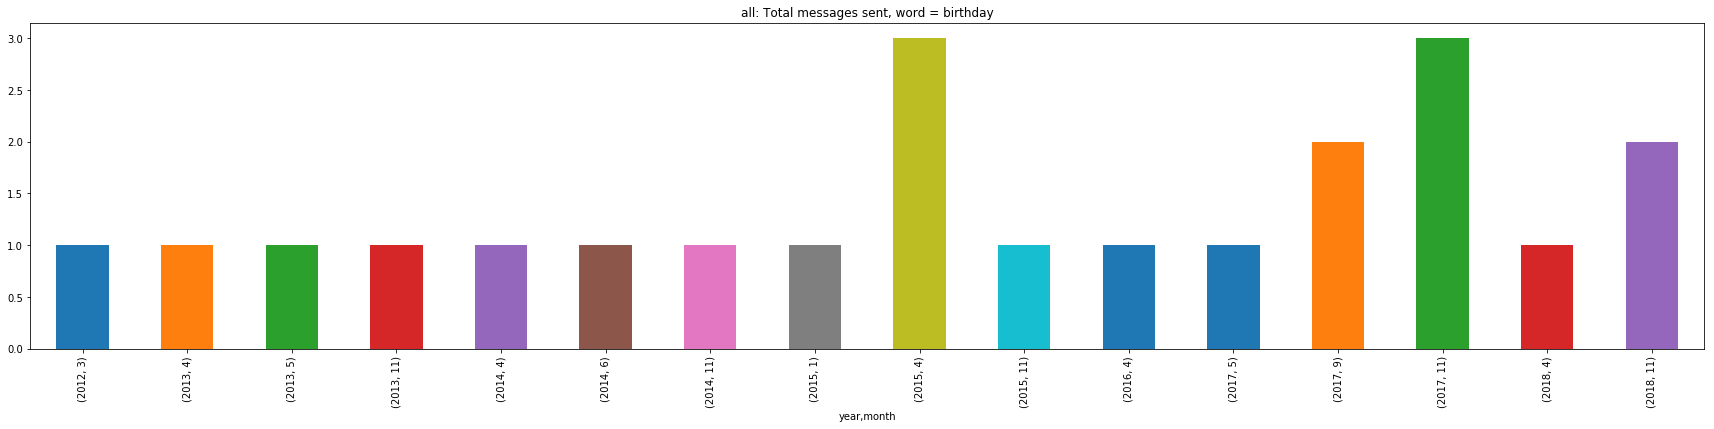

In [7]:
plot_word(person = 'all', word = 'birthday', mode = 'messages', precision = 'month', save=False)

In [8]:
def get_conversation(date, maxlength=999999): #(YYYY-MM-DD)
    conv = data[data['date']==date].sort_values(by='timestamp', ascending=True)[['time', 'sender_name', 'content']].head(maxlength)
    if len(conv)==0:
        return(f'No conversation on {date}')
    else:
        return conv

In [17]:
#get_conversation('2018-04-02', maxlength=10)

In [10]:
def find_word(word, maxlength=999999):
    instances = data[data['content_list'].apply(lambda words: word.lower() in words)].sort_values(by='timestamp', ascending=True)[['date', 'sender_name', 'content']].head(maxlength)
    if len(instances)==0:
        return(f'No instances of word \'{word}\' found')
    else:
        return instances

In [16]:
#find_word('birthday', maxlength=10)

In [12]:
#Get list and set of words for each participant
words = {}
uniques = {}
for name in data['sender_name'].unique():
    words[name] = data[data['sender_name']==name]['content_list'].sum()
    uniques[name] = set(words[name])
    print(f'{name} has used {len(uniques[name])} unique words from a total {len(words[name])} words sent')

Dmitri has used 14066 unique words from a total 249630 words sent
Simon has used 10479 unique words from a total 148603 words sent


In [13]:
#Get the n most common words longer than a certain threshold
def top_n_uniques(name, n, thresh):
    try:
        print(f'{name}\'s top {n} words longer than {thresh} characters:\n{pd.Series(Counter([word for word in words[name] if len(word)>=thresh]).most_common()[:n])}\n')
    except:
        print('Not a valid name')

In [15]:
top_n_uniques('Dmitri', 10, 10)

Dmitri's top 10 words longer than 10 characters:
0    (everything, 145)
1    (apparently, 128)
2     (definitely, 95)
3     (absolutely, 94)
4    (interesting, 78)
5     (completely, 74)
6     (attachment, 66)
7     (chippenham, 58)
8     (understand, 39)
9     (experience, 37)
dtype: object

